# Classification Training Pipeline

This notebook implements a complete Graph Neural Network (GNN) pipeline for a 3-class classification task (`Low`, `Medium`, `High`).  It now includes additional metrics in hyperparameter tuning and enhanced model comparison visualizations.

## Table of Contents
1. [Environment & Setup](#step1)
2. [Model Definition](#step2)
3. [Evaluation Function](#step3)
4. [Hyperparameter Sweep (10-Fold CV)](#step4)
5. [Retraining & Validation (10-Fold CV)](#step5)
6. [Cross-Validation Results Visualization](#step6)
7. [Ensemble Averaging](#step7)
8. [Final Model Training & Test Evaluation](#step8)
9. [Baseline QSAR Comparison](#step9)

---

## Prerequisites
- PyTorch & PyTorch Geometric  
- scikit-learn  
- pandas, numpy, matplotlib  
- RDKit (only for feature extraction)  
- GPU recommended

Install requirements:
```bash
pip install torch torch-geometric scikit-learn pandas numpy matplotlib rdkit-pypi
```

---

<a id="step1"></a>
## Step 1: Environment & Setup
- Seed all random generators for reproducibility.  
- Define paths for data splits and output.  
- Detect GPU/CPU.

<a id="step2"></a>
## Step 2: Model Definition
Defines:
- `GAT`: stacks layers, global mean pool, and final linear head.

<a id="step3"></a>
## Step 3: Evaluation Function
`evaluate(model, loader)` returns concatenated logits and true labels.

<a id="step4"></a>
## Step 4: Hyperparameter Sweep (10-Fold CV)
**Updates:** Now tracks both **AUC-ROC** and **Balanced Accuracy** per fold.

- Grid search over `hidden_dim`, `dropout`, `lr`.  
- For each config, run 10-fold CV: train for 50 epochs, then evaluate validation set.
- Compute per-fold metrics:
  - **AUC-ROC** (one-vs-rest)
  - **Balanced Accuracy** (accounts for class imbalance)
- Record **mean ± std** for both metrics.
- Results DataFrame `sweep_df` now contains `mean_auc`, `std_auc`, `mean_balanced_acc`, and `std_balanced_acc`.

<a id="step5"></a>
## Step 5: Retraining & Validation (10-Fold CV)
- Retrain each fold with best hyperparameters and early stopping.  
- Save best model weights.  
- Compute per-fold classification metrics: accuracy, precision, recall, F1, AUC-ROC.  
- Save `crossval_summary.csv`.

<a id="step6"></a>
## Step 6: Cross-Validation Results Visualization
- Load `crossval_summary.csv`.  
- Plot bar charts for each metric across folds.  
- Print mean ± std.

<a id="step7"></a>
## Step 7: Ensemble Averaging
- Load fold checkpoints, run on test set, average logits.  
- Save `ensemble_preds.csv` (True vs. Pred).
- **Ensemble evaluation plots** include confusion matrix and per-class ROC curves.

<a id="step8"></a>
## Step 8: Final Model Training & Test Evaluation
- Merge all train+val folds, reserve 10% for validation.  
- Train final model with early stopping and LR scheduler.  
- Evaluate on hold-out test: accuracy, precision, recall, F1, AUC-ROC.
- Plot confusion matrix and per-class ROC curves.  
- Save `final_model_metrics.csv`, `final_confusion_matrix.png`, and `final_auc_roc.png`.


---

## Parameters & Extensions
- **Epochs:** 50 for CV, 100 for final training  
- **Patience:** 10 for early stopping  
- **LR Scheduler:** `ReduceLROnPlateau` on validation loss  





## 1. Imports and Setup

In [39]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.nn import GATConv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import random

## 2. Task and Reproducibility Setup

In [40]:
# Set seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False

# DataLoader seeding
from torch.utils.data import DataLoader as _DL
from torch.utils.data import get_worker_info

def seed_worker(worker_id):
    worker_seed = seed + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator()
generator.manual_seed(seed)

task = "classification"  # or "regression"
#task = "regression"  # or "classification"
num_classes = 3
class_names = {0: "Low", 1: "Medium", 2: "High"}
kfold = 10
base_path = f"../4_train_test_split/10fold_cv/{task}/"
results_dir = f"GAT_results/{task}_{kfold}fold/"
os.makedirs(results_dir, exist_ok=True)

## 3b. Define GAT Model

In [41]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout, heads=8):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout)
        self.lin = Linear(hidden_channels * heads, out_channels)
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = global_mean_pool(x, batch)  # Aggregate node features to graph level
        return self.lin(x)

# class GAT(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels, heads, dropout, edge_dim):
#         super().__init__()
#         self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout, edge_dim=edge_dim)
#         self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=False, dropout=dropout, edge_dim=edge_dim)
#         self.lin = Linear(hidden_channels * heads, out_channels)

#     def forward(self, data):
#         # 从 data 对象中获取所需的所有属性
#         x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

#         x = self.conv1(x, edge_index, edge_attr).relu()  # 注意这里传入 edge_attr
#         x = self.conv2(x, edge_index, edge_attr).relu()  # 这里也传入 edge_attr
        
#         x = global_mean_pool(x, batch)
        
#         return x
    

## 4. Evaluation Helper Function

In [42]:
def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            preds.append(out.cpu())
            labels.append(batch.y.cpu())
    return torch.cat(preds), torch.cat(labels)

## 5. Input Dimensions and Device Setup

In [43]:
sample_data = torch.load(os.path.join(base_path, f"{task}_train_fold0.pt"))[0]
input_dim = sample_data.x.size(1)
edge_dim = sample_data.edge_attr.size(1)
output_dim = num_classes if task == "classification" else 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/1340473836.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sample_data = torch.load(os.path.join(base_pa

# ## Step 4: Select Best Hyperparameters
# Use this section to manually define the best hyperparameters based on the sweep above.


In [44]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import label_binarize
import numpy as np
import pandas as pd

# hidden_channels = [64, 128, 256]
# dropouts    = [0.0, 0.2, 0.4]
# lrs         = [1e-3, 5e-4, 1e-4]

hidden_channels = [64]
dropouts    = [0.4]
lrs         = [1e-3]

results = []

for hd in hidden_channels:
    for dp in dropouts:
        for lr in lrs:
            print(f"\n🔧 Config: hidden_dim={hd}, dropout={dp}, lr={lr}")
            auc_scores = []
            bal_scores = []
            for fold in range(10):
                # Load fold data
                train_data = torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
                val_data   = torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))
                
                model = GAT(in_channels=train_data[0].x.size(1), hidden_channels=hd,
                            out_channels=num_classes, heads=1, dropout=dp).to(device)
                        # GAT(train_data[0].x.size(1),
                        #      train_data[0].edge_attr.size(1),
                        #      output_dim=num_classes,
                        #      dropout=dp).to(device)
                opt = torch.optim.Adam(model.parameters(), lr=lr)
                tr = DataLoader(train_data, batch_size=32, shuffle=True,
                                worker_init_fn=seed_worker, generator=generator)
                vl = DataLoader(val_data,   batch_size=32)

                # Train
                for epoch in range(1, 51):
                    model.train()
                    for batch in tr:
                        batch = batch.to(device)
                        opt.zero_grad()
                        out = model(batch)
                        loss = F.cross_entropy(out, batch.y.long())
                        loss.backward()
                        opt.step()

                # Eval
                preds, labels = evaluate(model, vl)
                y_true = labels.numpy().astype(int)
                y_probs = F.softmax(preds, dim=1).numpy()
                y_pred  = preds.argmax(dim=1).numpy()

                # AUC‑ROC (one-vs-rest)
                auc = roc_auc_score(
                    label_binarize(y_true, classes=np.arange(num_classes)),
                    y_probs, multi_class='ovr'
                )
                auc_scores.append(auc)

                # Balanced Accuracy
                bal = balanced_accuracy_score(y_true, y_pred)
                bal_scores.append(bal)

            # Record mean±std for both metrics
            results.append({
                "hidden_dim": hd,
                "dropout":    dp,
                "lr":         lr,
                "mean_auc":   np.mean(auc_scores),
                "std_auc":    np.std(auc_scores),
                "mean_balanced_acc": np.mean(bal_scores),
                "std_balanced_acc":  np.std(bal_scores),
            })

            print(f"📊 AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f} | "
                  f"Balanced Acc: {np.mean(bal_scores):.4f} ± {np.std(bal_scores):.4f}")

# Build DataFrame and sort by mean balanced accuracy (or mean_auc)
sweep_df = pd.DataFrame(results)
display(sweep_df.sort_values("mean_balanced_acc", ascending=False))
# Save the results
sweep_df.to_csv(os.path.join(results_dir, "sweep_results.csv"), index=False)



🔧 Config: hidden_dim=64, dropout=0.4, lr=0.001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/2698709883.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 AUC: 0.7388 ± 0.0440 | Balanced Acc: 0.4955 ± 0.0267


,hidden_dim,dropout,lr,mean_auc,std_auc,mean_balanced_acc,std_balanced_acc
0,64,0.4,0.001,0.738808,0.04398,0.495542,0.026746


In [45]:

# Load the best model configuration
best_config = sweep_df.loc[sweep_df["mean_balanced_acc"].idxmax()]
best_hidden_dim = best_config["hidden_dim"]
best_dropout = best_config["dropout"]
best_lr = best_config["lr"]
print(f"Best config: hidden_dim={best_hidden_dim}, dropout={best_dropout}, lr={best_lr}")

Best config: hidden_dim=64.0, dropout=0.4, lr=0.001


# ## Step 5a: Retrain All Folds with Best Hyperparameters

In [46]:
# %%
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import pandas as pd
fold_metrics = []


for fold in range(10):
    print(f"\n🔁 Retraining Fold {fold+1}/10")
    train_data = torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
    val_data   = torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))

    model = GAT(in_channels=train_data[0].x.size(1), hidden_channels=hd,
                out_channels=num_classes, heads=1, dropout=dp).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=best_lr)
    tr = DataLoader(train_data, batch_size=32, shuffle=True,
                    worker_init_fn=seed_worker, generator=generator)
    vl = DataLoader(val_data,   batch_size=32)

    best_val_loss = float('inf'); patience=0
    for epoch in range(1, 101):
        model.train(); total_loss=0
        for batch in tr:
            batch=batch.to(device); opt.zero_grad(); out=model(batch)
            loss=F.cross_entropy(out,batch.y.long()); loss.backward(); opt.step(); total_loss+=loss.item()
        preds, labels = evaluate(model, vl)
        y_true = labels.numpy().astype(int)
        y_probs = F.softmax(preds, dim=1).numpy()
        val_loss = F.cross_entropy(preds, labels.long()).item()
        print(f"Epoch {epoch:03d} | Train Loss: {total_loss / len(tr):.4f} | Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss<best_val_loss:
            best_val_loss=val_loss; patience=0
            torch.save(model.state_dict(), os.path.join(results_dir, f"fold{fold+1}_model.pt"))
        else:
            patience+=1
            if patience>=10: break
    print(f"Best val loss: {best_val_loss:.4f} | Early stopping patience: {patience}")
    

    # Metrics
    y_pred = preds.argmax(dim=1).numpy()
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    auc = roc_auc_score(label_binarize(y_true, classes=np.arange(num_classes)), y_probs, multi_class='ovr')
    fold_metrics.append({"fold":fold+1,"accuracy":acc,"precision":precision,"recall":recall,"f1_score":f1,"auc_roc":auc})

# Save CV summary
cv_df = pd.DataFrame(fold_metrics)
cv_df.to_csv(os.path.join(results_dir, "crossval_summary.csv"), index=False)
print("✅ Saved CV summary")



🔁 Retraining Fold 1/10


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/636318835.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path

Epoch 001 | Train Loss: 0.9495 | Val Loss: 0.8947
Epoch 002 | Train Loss: 0.8848 | Val Loss: 0.8954
Epoch 003 | Train Loss: 0.8765 | Val Loss: 0.8795
Epoch 004 | Train Loss: 0.8680 | Val Loss: 0.8753
Epoch 005 | Train Loss: 0.8544 | Val Loss: 0.8684
Epoch 006 | Train Loss: 0.8727 | Val Loss: 0.8555
Epoch 007 | Train Loss: 0.8457 | Val Loss: 0.8397
Epoch 008 | Train Loss: 0.8270 | Val Loss: 0.8225
Epoch 009 | Train Loss: 0.8413 | Val Loss: 0.8106
Epoch 010 | Train Loss: 0.8223 | Val Loss: 0.7841
Epoch 011 | Train Loss: 0.7923 | Val Loss: 0.7699
Epoch 012 | Train Loss: 0.8012 | Val Loss: 0.7683
Epoch 013 | Train Loss: 0.7869 | Val Loss: 0.7640
Epoch 014 | Train Loss: 0.7980 | Val Loss: 0.7470
Epoch 015 | Train Loss: 0.8036 | Val Loss: 0.7392
Epoch 016 | Train Loss: 0.8132 | Val Loss: 0.7720
Epoch 017 | Train Loss: 0.7863 | Val Loss: 0.7438
Epoch 018 | Train Loss: 0.8061 | Val Loss: 0.7591
Epoch 019 | Train Loss: 0.7948 | Val Loss: 0.7382
Epoch 020 | Train Loss: 0.8034 | Val Loss: 0.7415


/Users/yao/Desktop/venv1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/636318835.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are ex

Epoch 001 | Train Loss: 0.9291 | Val Loss: 0.8763
Epoch 002 | Train Loss: 0.8832 | Val Loss: 0.8782
Epoch 003 | Train Loss: 0.8673 | Val Loss: 0.8709
Epoch 004 | Train Loss: 0.8809 | Val Loss: 0.8674
Epoch 005 | Train Loss: 0.8594 | Val Loss: 0.8578
Epoch 006 | Train Loss: 0.8633 | Val Loss: 0.8602
Epoch 007 | Train Loss: 0.8441 | Val Loss: 0.8523
Epoch 008 | Train Loss: 0.8406 | Val Loss: 0.8380
Epoch 009 | Train Loss: 0.8165 | Val Loss: 0.8315
Epoch 010 | Train Loss: 0.8166 | Val Loss: 0.8348
Epoch 011 | Train Loss: 0.8235 | Val Loss: 0.8200
Epoch 012 | Train Loss: 0.7911 | Val Loss: 0.8064
Epoch 013 | Train Loss: 0.7786 | Val Loss: 0.7994
Epoch 014 | Train Loss: 0.7981 | Val Loss: 0.8036
Epoch 015 | Train Loss: 0.7783 | Val Loss: 0.7943
Epoch 016 | Train Loss: 0.7644 | Val Loss: 0.7928
Epoch 017 | Train Loss: 0.7706 | Val Loss: 0.7956
Epoch 018 | Train Loss: 0.8210 | Val Loss: 0.7877
Epoch 019 | Train Loss: 0.7730 | Val Loss: 0.7901
Epoch 020 | Train Loss: 0.7553 | Val Loss: 0.7877


/Users/yao/Desktop/venv1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/636318835.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are ex

Epoch 001 | Train Loss: 0.9119 | Val Loss: 0.8671
Epoch 002 | Train Loss: 0.8842 | Val Loss: 0.8634
Epoch 003 | Train Loss: 0.8781 | Val Loss: 0.8615
Epoch 004 | Train Loss: 0.8768 | Val Loss: 0.8600
Epoch 005 | Train Loss: 0.8761 | Val Loss: 0.8577
Epoch 006 | Train Loss: 0.8812 | Val Loss: 0.8578
Epoch 007 | Train Loss: 0.8726 | Val Loss: 0.8547
Epoch 008 | Train Loss: 0.8837 | Val Loss: 0.8499
Epoch 009 | Train Loss: 0.8727 | Val Loss: 0.8141
Epoch 010 | Train Loss: 0.8352 | Val Loss: 0.8130
Epoch 011 | Train Loss: 0.8214 | Val Loss: 0.8097
Epoch 012 | Train Loss: 0.8322 | Val Loss: 0.8218
Epoch 013 | Train Loss: 0.8093 | Val Loss: 0.8316
Epoch 014 | Train Loss: 0.8071 | Val Loss: 0.7762
Epoch 015 | Train Loss: 0.7709 | Val Loss: 0.8228
Epoch 016 | Train Loss: 0.8035 | Val Loss: 0.7681
Epoch 017 | Train Loss: 0.7780 | Val Loss: 0.8265
Epoch 018 | Train Loss: 0.7554 | Val Loss: 0.7774
Epoch 019 | Train Loss: 0.8097 | Val Loss: 0.7853
Epoch 020 | Train Loss: 0.7890 | Val Loss: 0.7836


/Users/yao/Desktop/venv1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/636318835.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are ex

Epoch 002 | Train Loss: 0.8927 | Val Loss: 0.8455
Epoch 003 | Train Loss: 0.8608 | Val Loss: 0.8412
Epoch 004 | Train Loss: 0.8526 | Val Loss: 0.8421
Epoch 005 | Train Loss: 0.8461 | Val Loss: 0.8479
Epoch 006 | Train Loss: 0.8469 | Val Loss: 0.8401
Epoch 007 | Train Loss: 0.8389 | Val Loss: 0.8304
Epoch 008 | Train Loss: 0.8242 | Val Loss: 0.8242
Epoch 009 | Train Loss: 0.8286 | Val Loss: 0.8118
Epoch 010 | Train Loss: 0.8151 | Val Loss: 0.8304
Epoch 011 | Train Loss: 0.8079 | Val Loss: 0.7881
Epoch 012 | Train Loss: 0.7944 | Val Loss: 0.7842
Epoch 013 | Train Loss: 0.8088 | Val Loss: 0.7873
Epoch 014 | Train Loss: 0.7648 | Val Loss: 0.7739
Epoch 015 | Train Loss: 0.7840 | Val Loss: 0.7753
Epoch 016 | Train Loss: 0.7856 | Val Loss: 0.7629
Epoch 017 | Train Loss: 0.7790 | Val Loss: 0.7609
Epoch 018 | Train Loss: 0.7787 | Val Loss: 0.7729
Epoch 019 | Train Loss: 0.7585 | Val Loss: 0.7539
Epoch 020 | Train Loss: 0.7913 | Val Loss: 0.7732
Epoch 021 | Train Loss: 0.7739 | Val Loss: 0.7756


/Users/yao/Desktop/venv1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/636318835.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are ex

Epoch 002 | Train Loss: 0.8929 | Val Loss: 0.9165
Epoch 003 | Train Loss: 0.8706 | Val Loss: 0.9022
Epoch 004 | Train Loss: 0.8725 | Val Loss: 0.9007
Epoch 005 | Train Loss: 0.8706 | Val Loss: 0.8989
Epoch 006 | Train Loss: 0.8833 | Val Loss: 0.9034
Epoch 007 | Train Loss: 0.8746 | Val Loss: 0.8940
Epoch 008 | Train Loss: 0.8675 | Val Loss: 0.8831
Epoch 009 | Train Loss: 0.8578 | Val Loss: 0.8651
Epoch 010 | Train Loss: 0.8202 | Val Loss: 0.8520
Epoch 011 | Train Loss: 0.8392 | Val Loss: 0.8712
Epoch 012 | Train Loss: 0.8091 | Val Loss: 0.8331
Epoch 013 | Train Loss: 0.7970 | Val Loss: 0.8359
Epoch 014 | Train Loss: 0.7933 | Val Loss: 0.8191
Epoch 015 | Train Loss: 0.7862 | Val Loss: 0.8089
Epoch 016 | Train Loss: 0.7685 | Val Loss: 0.8089
Epoch 017 | Train Loss: 0.7931 | Val Loss: 0.8051
Epoch 018 | Train Loss: 0.7915 | Val Loss: 0.8439
Epoch 019 | Train Loss: 0.8084 | Val Loss: 0.8045
Epoch 020 | Train Loss: 0.7537 | Val Loss: 0.8101
Epoch 021 | Train Loss: 0.7763 | Val Loss: 0.7952


/Users/yao/Desktop/venv1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/636318835.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are ex

Epoch 002 | Train Loss: 0.8918 | Val Loss: 0.9033
Epoch 003 | Train Loss: 0.8673 | Val Loss: 0.9026
Epoch 004 | Train Loss: 0.8718 | Val Loss: 0.8986
Epoch 005 | Train Loss: 0.8759 | Val Loss: 0.8966
Epoch 006 | Train Loss: 0.8637 | Val Loss: 0.8792
Epoch 007 | Train Loss: 0.8434 | Val Loss: 0.8720
Epoch 008 | Train Loss: 0.8281 | Val Loss: 0.8562
Epoch 009 | Train Loss: 0.8054 | Val Loss: 0.8383
Epoch 010 | Train Loss: 0.8028 | Val Loss: 0.8363
Epoch 011 | Train Loss: 0.7988 | Val Loss: 0.8253
Epoch 012 | Train Loss: 0.7959 | Val Loss: 0.8243
Epoch 013 | Train Loss: 0.7756 | Val Loss: 0.8145
Epoch 014 | Train Loss: 0.7621 | Val Loss: 0.8101
Epoch 015 | Train Loss: 0.7813 | Val Loss: 0.8331
Epoch 016 | Train Loss: 0.7862 | Val Loss: 0.8050
Epoch 017 | Train Loss: 0.7635 | Val Loss: 0.8245
Epoch 018 | Train Loss: 0.7808 | Val Loss: 0.8063
Epoch 019 | Train Loss: 0.7840 | Val Loss: 0.8163
Epoch 020 | Train Loss: 0.7930 | Val Loss: 0.8079
Epoch 021 | Train Loss: 0.7861 | Val Loss: 0.8162


/Users/yao/Desktop/venv1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/636318835.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are ex

Epoch 001 | Train Loss: 1.0278 | Val Loss: 0.8806
Epoch 002 | Train Loss: 0.8981 | Val Loss: 0.8602
Epoch 003 | Train Loss: 0.8972 | Val Loss: 0.8572
Epoch 004 | Train Loss: 0.8773 | Val Loss: 0.8561
Epoch 005 | Train Loss: 0.8787 | Val Loss: 0.8521
Epoch 006 | Train Loss: 0.8707 | Val Loss: 0.8525
Epoch 007 | Train Loss: 0.8757 | Val Loss: 0.8479
Epoch 008 | Train Loss: 0.8611 | Val Loss: 0.8325
Epoch 009 | Train Loss: 0.8636 | Val Loss: 0.8224
Epoch 010 | Train Loss: 0.8317 | Val Loss: 0.8275
Epoch 011 | Train Loss: 0.8324 | Val Loss: 0.7951
Epoch 012 | Train Loss: 0.7956 | Val Loss: 0.7773
Epoch 013 | Train Loss: 0.7998 | Val Loss: 0.7768
Epoch 014 | Train Loss: 0.7938 | Val Loss: 0.7592
Epoch 015 | Train Loss: 0.7962 | Val Loss: 0.8003
Epoch 016 | Train Loss: 0.7908 | Val Loss: 0.7479
Epoch 017 | Train Loss: 0.7718 | Val Loss: 0.7550
Epoch 018 | Train Loss: 0.7784 | Val Loss: 0.7423
Epoch 019 | Train Loss: 0.7755 | Val Loss: 0.7551
Epoch 020 | Train Loss: 0.7468 | Val Loss: 0.7315


/Users/yao/Desktop/venv1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/636318835.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are ex

Epoch 001 | Train Loss: 0.9886 | Val Loss: 0.8692
Epoch 002 | Train Loss: 0.8716 | Val Loss: 0.8644
Epoch 003 | Train Loss: 0.8630 | Val Loss: 0.8581
Epoch 004 | Train Loss: 0.8694 | Val Loss: 0.8558
Epoch 005 | Train Loss: 0.8397 | Val Loss: 0.8414
Epoch 006 | Train Loss: 0.8530 | Val Loss: 0.8367
Epoch 007 | Train Loss: 0.8161 | Val Loss: 0.8223
Epoch 008 | Train Loss: 0.8094 | Val Loss: 0.8104
Epoch 009 | Train Loss: 0.8196 | Val Loss: 0.8006
Epoch 010 | Train Loss: 0.7933 | Val Loss: 0.8042
Epoch 011 | Train Loss: 0.7656 | Val Loss: 0.7769
Epoch 012 | Train Loss: 0.7992 | Val Loss: 0.7965
Epoch 013 | Train Loss: 0.7741 | Val Loss: 0.7880
Epoch 014 | Train Loss: 0.7954 | Val Loss: 0.7810
Epoch 015 | Train Loss: 0.7700 | Val Loss: 0.7838
Epoch 016 | Train Loss: 0.7920 | Val Loss: 0.7791
Epoch 017 | Train Loss: 0.7802 | Val Loss: 0.7977
Epoch 018 | Train Loss: 0.8105 | Val Loss: 0.7879
Epoch 019 | Train Loss: 0.7664 | Val Loss: 0.7851
Epoch 020 | Train Loss: 0.7788 | Val Loss: 0.7993


/Users/yao/Desktop/venv1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/636318835.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are ex

Epoch 001 | Train Loss: 1.0179 | Val Loss: 0.9013
Epoch 002 | Train Loss: 0.8756 | Val Loss: 0.8825
Epoch 003 | Train Loss: 0.8589 | Val Loss: 0.8709
Epoch 004 | Train Loss: 0.8554 | Val Loss: 0.8584
Epoch 005 | Train Loss: 0.8175 | Val Loss: 0.8420
Epoch 006 | Train Loss: 0.8202 | Val Loss: 0.8243
Epoch 007 | Train Loss: 0.8217 | Val Loss: 0.8257
Epoch 008 | Train Loss: 0.7936 | Val Loss: 0.8098
Epoch 009 | Train Loss: 0.7943 | Val Loss: 0.8006
Epoch 010 | Train Loss: 0.7917 | Val Loss: 0.7944
Epoch 011 | Train Loss: 0.7625 | Val Loss: 0.7991
Epoch 012 | Train Loss: 0.7849 | Val Loss: 0.7959
Epoch 013 | Train Loss: 0.7747 | Val Loss: 0.7925
Epoch 014 | Train Loss: 0.7860 | Val Loss: 0.7831
Epoch 015 | Train Loss: 0.7794 | Val Loss: 0.7850
Epoch 016 | Train Loss: 0.7997 | Val Loss: 0.7969
Epoch 017 | Train Loss: 0.7858 | Val Loss: 0.7829
Epoch 018 | Train Loss: 0.7856 | Val Loss: 0.7941
Epoch 019 | Train Loss: 0.7992 | Val Loss: 0.7914
Epoch 020 | Train Loss: 0.8034 | Val Loss: 0.7837


/Users/yao/Desktop/venv1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/636318835.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are ex

Epoch 001 | Train Loss: 0.9057 | Val Loss: 0.8738
Epoch 002 | Train Loss: 0.8838 | Val Loss: 0.8691
Epoch 003 | Train Loss: 0.8750 | Val Loss: 0.8649
Epoch 004 | Train Loss: 0.8583 | Val Loss: 0.8616
Epoch 005 | Train Loss: 0.8478 | Val Loss: 0.8590
Epoch 006 | Train Loss: 0.8498 | Val Loss: 0.8576
Epoch 007 | Train Loss: 0.8283 | Val Loss: 0.8418
Epoch 008 | Train Loss: 0.8193 | Val Loss: 0.8345
Epoch 009 | Train Loss: 0.8154 | Val Loss: 0.8400
Epoch 010 | Train Loss: 0.8231 | Val Loss: 0.8356
Epoch 011 | Train Loss: 0.8219 | Val Loss: 0.8156
Epoch 012 | Train Loss: 0.7963 | Val Loss: 0.8250
Epoch 013 | Train Loss: 0.7656 | Val Loss: 0.8038
Epoch 014 | Train Loss: 0.7795 | Val Loss: 0.8100
Epoch 015 | Train Loss: 0.7979 | Val Loss: 0.8261
Epoch 016 | Train Loss: 0.7771 | Val Loss: 0.7960
Epoch 017 | Train Loss: 0.7940 | Val Loss: 0.8000
Epoch 018 | Train Loss: 0.7802 | Val Loss: 0.7941
Epoch 019 | Train Loss: 0.7612 | Val Loss: 0.7994
Epoch 020 | Train Loss: 0.7508 | Val Loss: 0.7952


/Users/yao/Desktop/venv1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# ## Step 6: Visualize Cross-Validation Results


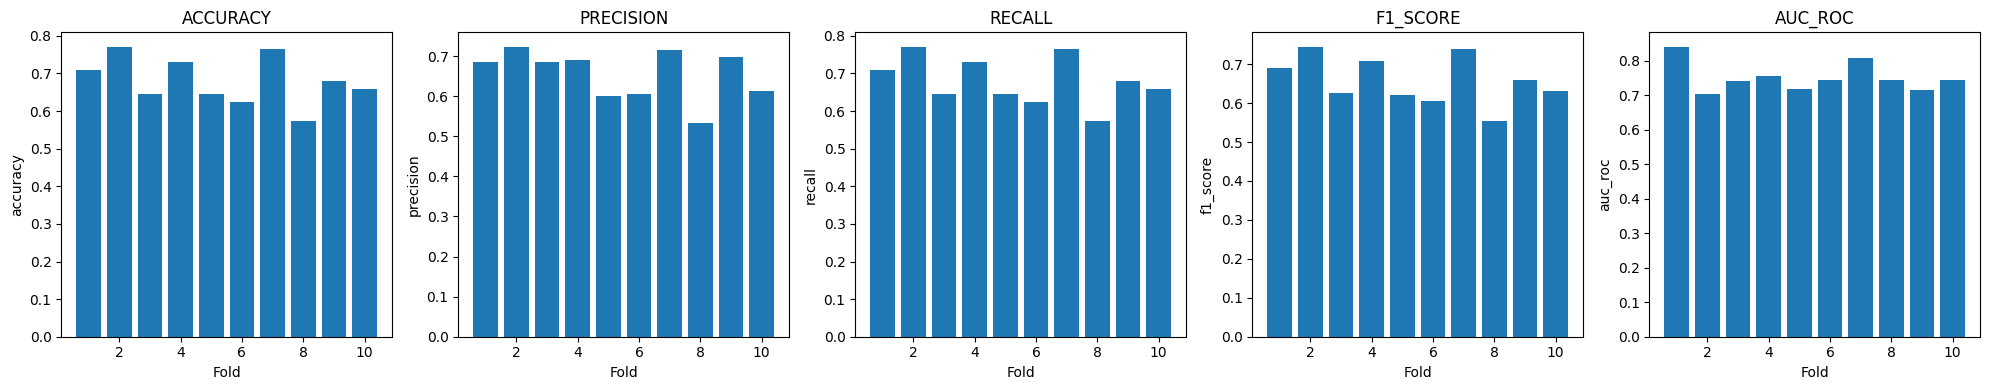

In [47]:

# %%
cv_df = pd.read_csv(os.path.join(results_dir, "crossval_summary.csv"))
metrics = ['accuracy','precision','recall','f1_score','auc_roc']
fig, axs = plt.subplots(1,len(metrics), figsize=(20,4))
for i,m in enumerate(metrics):
    axs[i].bar(cv_df['fold'], cv_df[m]); axs[i].set_title(m.upper()); axs[i].set_xlabel('Fold'); axs[i].set_ylabel(m)
plt.tight_layout(); plt.show()

# ## Step 7: Ensemble Averaging from 10 CV Models


In [49]:

# %%
ess_preds=[]
test_data=torch.load(os.path.join(base_path, f"{task}_test.pt"))
tl=DataLoader(test_data, batch_size=32)
for fold in range(10):
    model = GAT(in_channels=train_data[0].x.size(1), hidden_channels=hd,
                out_channels=num_classes, heads=1, dropout=dp).to(device)
    model.load_state_dict(torch.load(os.path.join(results_dir, f"fold{fold+1}_model.pt")))
    model.eval(); outs=[]
    with torch.no_grad():
        for b in tl: outs.append(model(b.to(device)).cpu())
    ess_preds.append(torch.cat(outs,0))
avg=torch.stack(ess_preds).mean(0)
f_pred=avg.argmax(1).numpy(); t_true=torch.cat([d.y for d in test_data]).numpy().astype(int)
pd.DataFrame({'True':t_true,'Pred':f_pred}).to_csv(os.path.join(results_dir,'ensemble_preds.csv'),index=False)
print('✅ Ensemble preds saved')

/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/3519107944.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data=torch.load(os.path.join(base_path, 

✅ Ensemble preds saved


# ## Step 7b: Ensemble Model Evaluation – Confusion Matrix & AUC‑ROC


In [57]:
# Step 7: Ensemble Averaging on Test Set
test_data = torch.load(
    os.path.join(base_path, f"{task}_test.pt"),
    weights_only=False
)
test_loader = DataLoader(test_data, batch_size=32)
all_preds = []

for fold in range(kfold):
    model = GAT(in_channels=test_data[0].x.size(1), hidden_channels=best_hidden_dim,
            out_channels=num_classes, heads=1, dropout=best_dropout).to(device)
    model.load_state_dict(
        torch.load(
            os.path.join(results_dir, f"fold{fold+1}_model.pt"),
            weights_only=False
        )
    )
    model.eval()
    preds_fold = []
    with torch.no_grad():
        for b in test_loader:
            preds_fold.append(model(b.to(device)).cpu())
    all_preds.append(torch.cat(preds_fold))

avg_preds = torch.stack(all_preds).mean(0)
y_true    = torch.cat([d.y for d in test_data]).numpy().astype(int)
y_pred    = avg_preds.argmax(dim=1).numpy()
pd.DataFrame({"True": y_true, "Pred": y_pred})\
  .to_csv(os.path.join(results_dir, "gcn_ensemble_preds.csv"), index=False)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(
    cm, display_labels=[f"Class {i}" for i in range(num_classes)]
)
disp.plot(); plt.title("GCN Ensemble Confusion Matrix"); plt.show()

# AUC by class
y_probs    = F.softmax(avg_preds, dim=1).numpy()
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
plt.figure(figsize=(7,5))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc(fpr, tpr):.2f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("GCN Ensemble AUC by Class"); plt.legend(); plt.show()

TypeError: empty() received an invalid combination of arguments - got (numpy.float64, int), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (tuple of ints size, *, torch.memory_format memory_format = None, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)


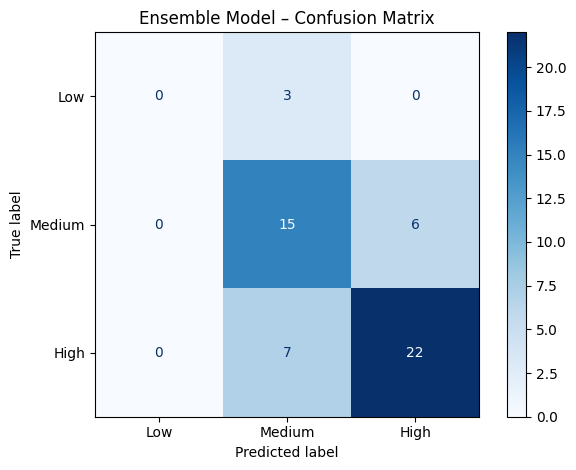

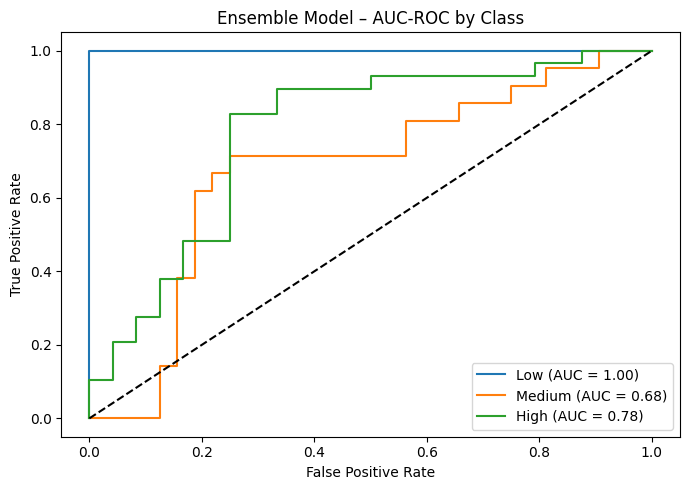

In [60]:

# %%
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Load ensemble predictions
ens_df = pd.read_csv(os.path.join(results_dir, 'ensemble_preds.csv'))
y_true_ens = ens_df['True'].values
y_pred_ens = ens_df['Pred'].values

# 1) Confusion matrix
cm = confusion_matrix(y_true_ens, y_pred_ens)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[class_names[i] for i in range(num_classes)])
disp.plot(cmap='Blues')
plt.title("Ensemble Model – Confusion Matrix")
plt.tight_layout()
plt.show()

# 2) AUC‑ROC per class
# Need probability estimates – reload avg_output if available or recompute probabilities
# If you only have hard preds, rerun ensemble loop with model outputs saved as probs:
#     avg_probs = torch.stack(ensemble_prob_lists).mean(0).numpy()
# For now, assuming you have `avg_probs`:
avg_output = avg
y_probs = avg_output.softmax(dim=1).numpy()  # or your stored avg_probs
y_true_bin = label_binarize(y_true_ens, classes=np.arange(num_classes))

plt.figure(figsize=(7,5))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc(fpr, tpr):.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Ensemble Model – AUC‑ROC by Class")
plt.legend()
plt.tight_layout()
plt.show()


# ## Step 8: Final Model Training on Combined Data & Test Evaluation


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/170317506.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_data+=torch.load(os.path.join(base_path,f

Epoch 001 | Train Loss: 0.8523 | Val Loss: 0.7937 | Best Val Loss: 0.7937 | Patience: 0
Epoch 002 | Train Loss: 0.7796 | Val Loss: 0.7588 | Best Val Loss: 0.7588 | Patience: 0
Epoch 003 | Train Loss: 0.7651 | Val Loss: 0.7480 | Best Val Loss: 0.7480 | Patience: 0
Epoch 004 | Train Loss: 0.7634 | Val Loss: 0.7566 | Best Val Loss: 0.7480 | Patience: 1
Epoch 005 | Train Loss: 0.7570 | Val Loss: 0.7629 | Best Val Loss: 0.7480 | Patience: 2
Epoch 006 | Train Loss: 0.7549 | Val Loss: 0.7436 | Best Val Loss: 0.7436 | Patience: 0
Epoch 007 | Train Loss: 0.7470 | Val Loss: 0.7507 | Best Val Loss: 0.7436 | Patience: 1
Epoch 008 | Train Loss: 0.7361 | Val Loss: 0.7423 | Best Val Loss: 0.7423 | Patience: 0
Epoch 009 | Train Loss: 0.7345 | Val Loss: 0.7083 | Best Val Loss: 0.7083 | Patience: 0
Epoch 010 | Train Loss: 0.7251 | Val Loss: 0.7152 | Best Val Loss: 0.7083 | Patience: 1
Epoch 011 | Train Loss: 0.7230 | Val Loss: 0.7347 | Best Val Loss: 0.7083 | Patience: 2
Epoch 012 | Train Loss: 0.7273 |

/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/170317506.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join

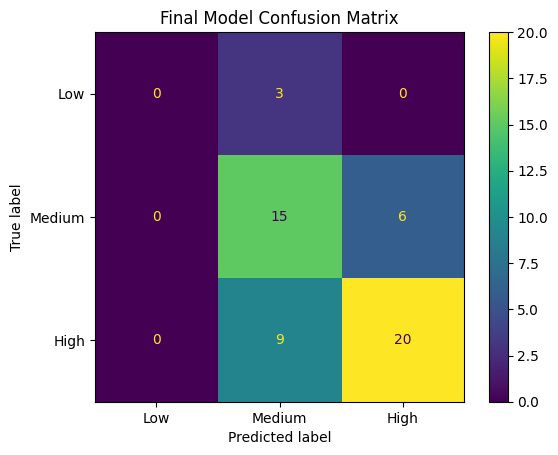

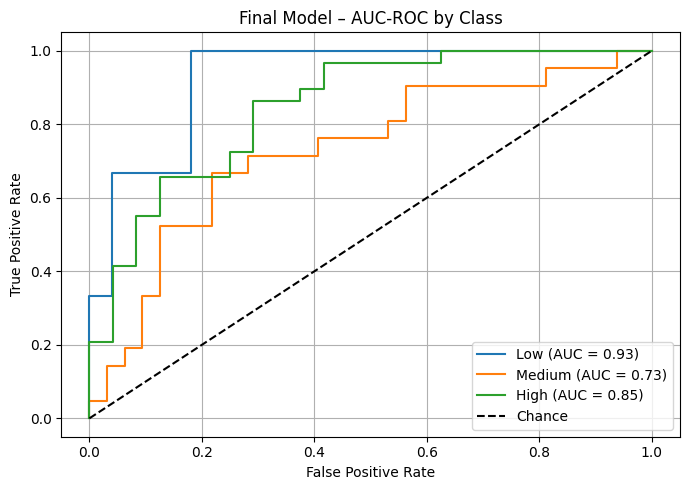

,Accuracy
ensemble,0.698113
final,0.660377


✅ Final metrics saved
✅ Final confusion matrix saved
✅ Final AUC-ROC saved
✅ Final predictions saved


In [68]:

# %%
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Merge train+val
all_data=[]
for fold in range(10):
    all_data+=torch.load(os.path.join(base_path,f"{task}_train_fold{fold}.pt"))
    all_data+=torch.load(os.path.join(base_path,f"{task}_val_fold{fold}.pt"))
# small val
sss=StratifiedShuffleSplit(n_splits=1,test_size=0.1,random_state=seed)
labels=[int(d.y.item()) for d in all_data]
train_idx,val_idx=next(sss.split(all_data,labels))
train_split=[all_data[i] for i in train_idx]; val_split=[all_data[i] for i in val_idx]
tr=DataLoader(train_split,batch_size=32,shuffle=True,worker_init_fn=seed_worker,generator=generator)
vl=DataLoader(val_split,batch_size=32)
model = GAT(in_channels=all_data[0].x.size(1), hidden_channels=int(best_hidden_dim),
                out_channels=num_classes, heads=1, dropout=best_dropout).to(device)
opt=torch.optim.Adam(model.parameters(),lr=best_lr)
sched=torch.optim.lr_scheduler.ReduceLROnPlateau(opt,mode='min',patience=5,factor=0.5,verbose=True)
best_v=1e9;pat=0
for epoch in range(1,301):
    model.train();tot=0
    for b in tr: b=b.to(device);opt.zero_grad();o=model(b);l=F.cross_entropy(o,b.y.long());l.backward();opt.step();tot+=l.item()
    preds,labels=evaluate(model,vl);vloss=F.cross_entropy(preds,labels.long()).item();sched.step(vloss)
    if vloss<best_v:best_v=vloss;pat=0;torch.save(model.state_dict(),os.path.join(results_dir,'final_model.pt'))
    else: pat+=1
    if pat>=10:break
    print(f"Epoch {epoch:03d} | Train Loss: {tot/len(tr):.4f} | Val Loss: {vloss:.4f} | Best Val Loss: {best_v:.4f} | Patience: {pat}")

# test eval
model.load_state_dict(torch.load(os.path.join(results_dir,'final_model.pt')))
td=DataLoader(torch.load(os.path.join(base_path,f"{task}_test.pt")),batch_size=32)
preds,labels=evaluate(model,td);y_pred=preds.argmax(1).numpy();y_true=labels.numpy().astype(int)
# metrics
acc_f=accuracy_score(y_true,y_pred);prec,rec,f1,_=precision_recall_fscore_support(y_true,y_pred,average='weighted')
# confusion
cm=confusion_matrix(y_true,y_pred);disp=ConfusionMatrixDisplay(cm,display_labels=list(class_names.values()));disp.plot()
plt.title('Final Model Confusion Matrix');plt.show()
# final auc
 # Assume y_true is shape (n,) and preds is torch.Tensor of shape (n, num_classes)
probs     = F.softmax(preds, dim=1).cpu().numpy()     # (n, C)
y_true    = labels.numpy().astype(int)                 # (n,)
y_true_bin= label_binarize(y_true, classes=np.arange(num_classes))  # (n, C)

plt.figure(figsize=(7, 5))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc     = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Final Model – AUC‑ROC by Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Comparison table
ensemble_df=pd.read_csv(os.path.join(results_dir,'ensemble_preds.csv'))
ensemble_acc=accuracy_score(ensemble_df['True'],ensemble_df['Pred'])
final_metrics = {'ensemble': ensemble_acc, 'final': acc_f}
comp = pd.DataFrame.from_dict(final_metrics, orient='index', columns=['Accuracy'])
display(comp)

# Save final metrics
final_metrics = {
    'accuracy': acc_f,
    'precision': prec,
    'recall': rec,
    'f1_score': f1,
    'auc_roc': roc_auc_score(label_binarize(y_true, classes=np.arange(num_classes)), probs, multi_class='ovr')
}
final_metrics_df = pd.DataFrame(final_metrics, index=[0])
final_metrics_df.to_csv(os.path.join(results_dir, 'final_metrics.csv'), index=False)
print("✅ Final metrics saved")
# Save final confusion matrix
cm_df = pd.DataFrame(cm, index=class_names.values(), columns=class_names.values())
cm_df.to_csv(os.path.join(results_dir, 'final_confusion_matrix.csv'))
print("✅ Final confusion matrix saved")
# Save final AUC-ROC
roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
roc_auc = auc(fpr, tpr)
roc_df.to_csv(os.path.join(results_dir, 'final_auc_roc.csv'), index=False)
print("✅ Final AUC-ROC saved")
# Save final predictions
preds_df = pd.DataFrame({'True': y_true, 'Pred': y_pred})
preds_df.to_csv(os.path.join(results_dir, 'final_predictions.csv'), index=False)
print("✅ Final predictions saved")


## Step 9: compare ensemble averaging to final model training results

In [70]:
# Comparison table
ensemble_df=pd.read_csv(os.path.join(results_dir,'ensemble_preds.csv'))
ensemble_acc=accuracy_score(ensemble_df['True'],ensemble_df['Pred'])
final_metrics = {'ensemble': ensemble_acc, 'final': acc_f}
comp = pd.DataFrame.from_dict(final_metrics, orient='index', columns=['Accuracy'])
display(comp)

,Accuracy
ensemble,0.698113
final,0.660377
